# **Previsão básica de ações utilizando Multi Layer Perceptron**

- Diogo Nunes Batista

### Carregamento dos dados

In [1]:
import pandas 
import numpy as np

STOCK_NAME = 'IRBR3'

df = pandas.read_csv(f'data/final/{STOCK_NAME}.csv', index_col='DATA', sep=';', decimal='.')
df

,ABERTURA,FECHAMENTO,VARIAÇÃO,MÍNIMO,MÁXIMO,VOLUME,SELIC
DATA,,,,,,,
25/04/2024,0.4080,0.4124,0.10118,0.4030,0.4140,0.04464,0.040168
26/04/2024,0.4153,0.4235,0.10269,0.4125,0.4276,0.05496,0.040168
29/04/2024,0.4215,0.4302,0.10158,0.4153,0.4327,0.03972,0.040168
30/04/2024,0.4298,0.4248,0.09874,0.4229,0.4378,0.06525,0.040168
02/05/2024,0.4337,0.4375,0.10299,0.4319,0.4478,0.09085,0.040168
...,...,...,...,...,...,...,...
21/10/2024,0.4186,0.4246,0.10194,0.4161,0.4256,0.02814,0.040168
22/10/2024,0.4245,0.4249,0.10007,0.4159,0.4253,0.02537,0.040168
23/10/2024,0.4280,0.4771,0.11229,0.4268,0.4815,0.15365,0.040168


### Separação input e target

In [2]:
# input = [(df[i:i+7].values, np.array([df.iat[i+7, 0]])) for i in range(0, df.index.size - 7)]
input = np.array([(df[i:i+7].to_numpy().flatten()) for i in range(0, df.index.size - 7)])
target = np.array([[df.iat[i+7, 0]] for i in range(0, df.index.size - 7)])

n_test = 7

x_train = input[:-n_test]
t_train = target[:-n_test]

x_test = input[-n_test:]
t_test = target[-n_test:]

x_train.shape, t_train.shape, x_test.shape, t_test.shape

((115, 49), (115, 1), (7, 49), (7, 1))

### Teste

Error: 0.0031170540763642003 - epochs: 10000


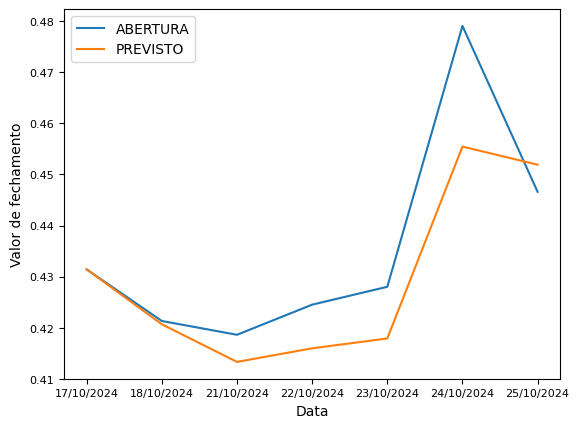

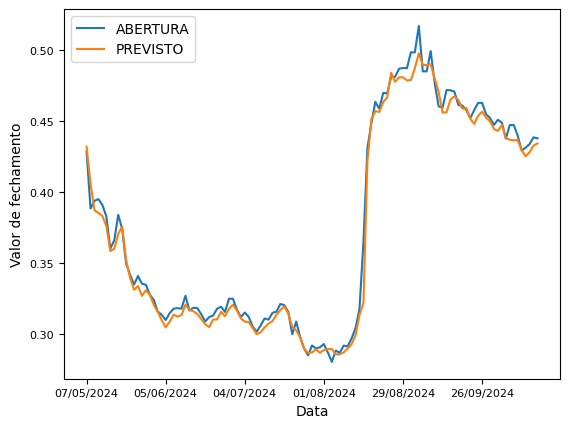

In [ ]:
from mlp_model import MLP

mlp = MLP(layers_sizes=[49, 150, 125, 75, 50, 25, 5, 1])
error, epochs = mlp.train(x_train, t_train, learning_rate=0.01, max_epochs=10000, tolerated_error=0.0001)
print(f'Error: {error} - epochs: {epochs}')

y_test = mlp.predict(x_test)
df_test = df.iloc[-n_test:].copy()
df_test['PREVISTO'] = y_test

df_test.plot(y=['ABERTURA', 'PREVISTO'], xlabel='Data', ylabel='Valor de fechamento', fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_1.png')

y = mlp.predict(x_train)

df_predict = df.iloc[7:-n_test].copy()
df_predict['PREVISTO'] = y

df_predict.plot(y=['ABERTURA', 'PREVISTO'], xlabel='Data', ylabel='Valor de fechamento', fontsize=8).get_figure().savefig(f'results/{STOCK_NAME}_2.png')